In [3]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, timedelta
import sys

from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import geopandas as gpd

In [4]:
folder_path = "../"
sys.path.append(folder_path)
sys.path.append("../mobility_function/")
from mobility_function import analysis as ma
from importlib import reload
import mobility_function.analysis as ma
import mobility_function.hurricane_plotting as mhp
ma = reload(ma)
mhp = reload(mhp)

In [5]:
ymd_ofweek = np.load('ymd_ofweek.npy').tolist()
start_idx = ymd_ofweek.index('2023-09-11')
comparable_weeks = ymd_ofweek[start_idx:start_idx+8]
len(comparable_weeks)

8

In [6]:
Ms_h_base = np.load('Ms_h_base_2023.npy')
geo_idx = pd.read_csv('geoid_idx_names.csv')

In [7]:
Ms_h_base.shape

(7, 17, 3144, 3144)

In [6]:
from scipy.stats import gaussian_kde
def find_distribution(data):
    kde = gaussian_kde(data, bw_method='scott')  # or 'silverman', or a float like 0.2
    # Create a range of x values over which to evaluate KDE
    x_vals = np.linspace(min(data) - 1, max(data) + 1, 1000)
    pdf_vals = kde(x_vals)

    # Compute CDF from PDF
    cdf_vals = np.cumsum(pdf_vals)
    cdf_vals /= cdf_vals[-1]  # normalize

    # Find 2.5% and 97.5% thresholds
    x_025 = x_vals[np.searchsorted(cdf_vals, 0.025)]
    x_975 = x_vals[np.searchsorted(cdf_vals, 0.975)]
    bin_edges = np.linspace(-0.15, 0.15, 20)
    bins, _ = np.histogram(data, bin_edges, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = np.diff(bin_edges)[0]
    return pdf_vals, x_vals, x_025, x_975, bins, bin_centers, bin_width

In [7]:
def get_within_region_fluactions_ts(hrc_name,Ms_h_base,):
    # hrc_name = 'helene'
    cutoff_mile = 50
    print(cutoff_mile, hrc_name)
    ### region ids
    with open("../results/{}/counties_geoid_cut_{}.txt".format(hrc_name,cutoff_mile), "r") as f:
        county_list = [line.strip() for line in f]

    county_list = [int(x) for x in county_list]
    selected_idx = geo_idx[geo_idx['GEOID'].isin(county_list)].county_idx.values

    ### get the regions base visits
    M_base, _, _ = ma.region_mobility(Ms_h_base, selected_idx)
    M_base_sum_ts = np.sum(M_base, axis=1) ### from selected counties to within regions
    within_base_ts = np.sum(M_base_sum_ts, axis=1) # sum up the 7 days
    
    ts_within_all = np.zeros((len(comparable_weeks), 7))
    
    for i, wk in enumerate(comparable_weeks):
        print (wk)
        wk_i = datetime.strptime(wk, "%Y-%m-%d").strftime("%Y%m%d")
        Ms_wk_i = ma.h5py_to_4d_array(f'../data/mobility/M_raw_{wk_i}.h5')
        
        M_within_i, _, _ = ma.region_mobility(Ms_wk_i, selected_idx)
        M_within_ts_i = np.sum(M_within_i, axis=1)
        within_all_i = np.sum(M_within_ts_i, axis=1)
        # plt.plot(regout_all_i)
        ts_within_all[i] = within_all_i
        with np.errstate(divide='ignore', invalid='ignore'):
            fluctuation_percentages = np.where(
                within_base_ts == 0,
                0,  # or np.nan if preferred
                (within_all_i - within_base_ts) / within_base_ts
            )
        if i == 0:
            M_fluctuation = fluctuation_percentages
        else:
            M_fluctuation = np.concatenate([M_fluctuation, fluctuation_percentages], axis=0)
    return M_fluctuation, ts_within_all

In [8]:
ts_within_fluctuation_milton, ts_within_all_milton = get_within_region_fluactions_ts('milton', Ms_h_base)
ts_within_fluctuation_helene, ts_within_all_helene = get_within_region_fluactions_ts('helene', Ms_h_base)

50 milton
2023-09-11
2023-09-18
2023-09-25
2023-10-02
2023-10-09
2023-10-16
2023-10-23
2023-10-30
50 helene
2023-09-11
2023-09-18
2023-09-25
2023-10-02
2023-10-09
2023-10-16
2023-10-23
2023-10-30


In [10]:
pdf_vals_milton, x_vals_milton, x_025_milton, x_975_milton, bins_milton, bin_centers_milton, bin_width_milton = find_distribution(ts_within_fluctuation_milton)
pdf_vals_helene, x_vals_helene, x_025_helene, x_975_helene, bins_helene, bin_centers_helene, bin_width_helene = find_distribution(ts_within_fluctuation_helene)

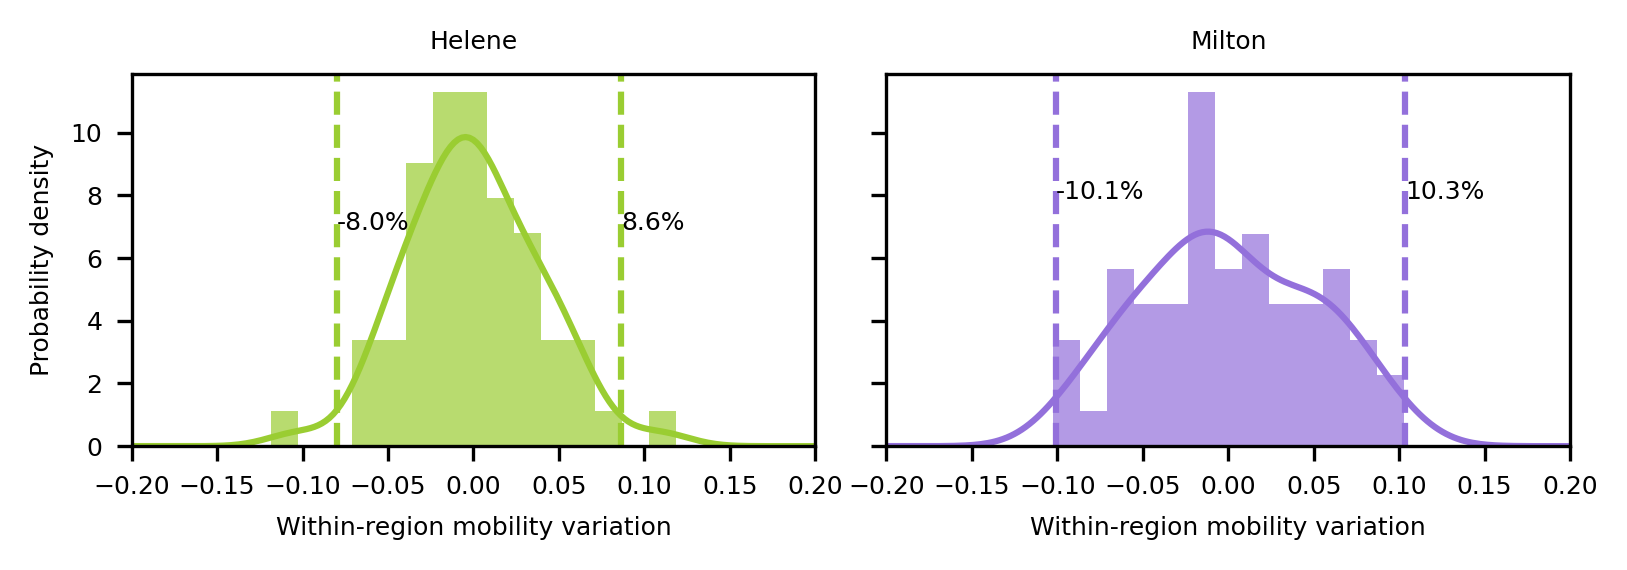

In [11]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), dpi=300, sharey=True)
#### helene
axs[0].bar(bin_centers_helene, bins_helene, alpha=0.7, label='Helene', color='yellowgreen', width=bin_width_helene)
axs[0].plot(x_vals_helene, pdf_vals_helene, color='yellowgreen')
axs[0].axvline(x_025_helene, color='yellowgreen', linestyle='--')
axs[0].axvline(x_975_helene, color='yellowgreen', linestyle='--')
axs[0].text(x_025_helene, 7.5, f'{x_025_helene * 100:.1f}%', color='black', fontsize=6,
            ha='left', va='top', bbox=dict(facecolor='none', alpha=1, edgecolor='none'))
axs[0].text(x_975_helene, 7.5, f'{x_975_helene * 100:.1f}%', color='black', fontsize=6,
            ha='left', va='top', bbox=dict(facecolor='none', alpha=1, edgecolor='none'))
axs[0].set_xlim(-0.2, 0.2)
axs[0].set_xlabel('Within-region mobility variation', fontsize=6)
axs[0].tick_params(axis='both', labelsize=6)
axs[0].set_title('Helene', fontsize=6)
axs[0].set_ylabel('Probability density', fontsize=6)
### milton
axs[1].bar(bin_centers_milton, bins_milton, alpha=0.7, label='Milton', color='mediumpurple', width=bin_width_milton)
axs[1].plot(x_vals_milton, pdf_vals_milton, color='mediumpurple')
axs[1].axvline(x_025_milton, color='mediumpurple', linestyle='--')
axs[1].axvline(x_975_milton, color='mediumpurple', linestyle='--')
axs[1].text(x_025_milton, 8.5, f'{x_025_milton * 100:.1f}%', color='black', fontsize=6,
            ha='left', va='top', bbox=dict(facecolor='none', alpha=1, edgecolor='none'))
axs[1].text(x_975_milton, 8.5, f'{x_975_milton * 100:.1f}%', color='black', fontsize=6,
            ha='left', va='top', bbox=dict(facecolor='none', alpha=1, edgecolor='none'))
axs[1].set_xlim(-0.2, 0.2)
axs[1].set_xlabel('Within-region mobility variation', fontsize=6)
axs[1].tick_params(axis='both', labelsize=6)
axs[1].set_title('Milton', fontsize=6)




plt.tight_layout(w_pad=0.5)
plt.savefig(f'../results/baseline_distribution_within_region.png', format = 'png',dpi=450,bbox_inches='tight',transparent=True)